# ⚪ Chest X-Ray Classification using Hermite Activations on ConvNeXt model ⚪

The primary goal of this project is to exhibit the efficiency of learnable activation functions based on orthogonal function bases as formulated by *(Khalfaoui-Hassani & Kesselheim)*. Traditional activations (ReLU, GeLU, tanh, log) remain fixed throughout learning, but each activation function here can be expressed as a linear combination of basis functions. This variance-preserving scheme ensures both forward and backward signal variances remain unitary throughout deep networks.

The dataset can be found on Kaggle: [Pulmonary Chest X-ray Abnomalities dataset](https://www.kaggle.com/datasets/kmader/pulmonary-chest-xray-abnormalities/data). The model's architecture is based on the [ConvNext model](https://arxiv.org/abs/2201.03545).

I will be using the PyTorch library provided at [torchortho repository](https://github.com/K-H-Ismail/torchortho/tree/main).

## 🌲 Environment Setup

In [ ]:
# Data Processing
import math
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split

# Image processing
from PIL import Image
import matplotlib.pyplot as plt

# ML
import torch

# Others
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import kagglehub

## 💾 Dataset Processing

#### Download dataset from Kaggle

In [ ]:
# print(os.getcwd())
# os.chroot() as needed

# data_path = "data/"
# os.environ['KAGGLEHUB_CACHE'] = data_path   # Set KAGGLEHUB_CACHE to download location


# if not os.path.exists(data_path):
#     os.mkdir("./data/")

# # Download latest version
# kagglehub.dataset_download("kmader/pulmonary-chest-xray-abnormalities") 

In [ ]:
# Clean up needed folders

import shutil

# shutil.move("data/datasets/kmader/pulmonary-chest-xray-abnormalities/versions/1/ChinaSet_AllFiles/ChinaSet_AllFiles", "data")
# shutil.move("data/datasets/kmader/pulmonary-chest-xray-abnormalities/versions/1/Montgomery/MontgomerySet", "data")

# shutil.rmtree("data/datasets")

#### Process Data

In [ ]:
ch_dir = 'data/ChinaSet_AllFiles/CXR_png'
mont_dir  = 'data/MontgomerySet/CXR_png'

# Image directories
ch_img_dir = os.listdir(ch_dir)
mont_img_dir = os.listdir(mont_dir)
imgs = ch_img_dir + mont_img_dir

def load_image(path: str, target_size: tuple[int, int]=None) -> np.ndarray:
    """
    Reads an image with Pillow and returns an (H, W, 3) RGB uint8 array
    If target_size(h, w) is given, it will resize using a high-quality filter
    """
    with Image.open(path) as img:
        img = img.convert("RGB")

        if target_size is not None:
            width, height = target_size[1], target_size[0]
            img = img.resize((width, height), Image.Resampling.LANCZOS)

        return np.array(img)
    

records = []

for img in imgs:
    if img[-3:] != 'png':
        continue

    flag = 'CH' if img[:2] == 'CH' else 'MT'
    img_path = os.path.join(ch_dir, img) if flag == 'CH' else os.path.join(mont_dir, img)

    if not os.path.exists(img_path):
        print(f"Warning: {img_path} not found, skipping.")
        continue

    # load & resize to (h, w)
    arr = load_image(img_path)

    # Each image will have flag of dataset it's from, the image contained as cv::Mat, and diagnosis 
    rec = {'flag': flag, 'image': arr, 'res': bool(int(img[-5]))}
    records.append(rec)

img_df = pd.DataFrame(records)

def show_images_from_df(df, image_col="image", title_col=None, fig_title=None, n=8, n_cols=4, figsize=(10, 6)):
    n = min(n, len(df))
    n_cols = min(n_cols, n)
    n_rows = math.ceil(n / n_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()
    indices = np.random.randint(0, len(df), n)
    

    for i, idx in enumerate(indices):

        ax = axes[i]
        img = df.iloc[idx][image_col]
        ax.imshow(img)
        ax.axis("off")

        if title_col:
            ax.set_xlabel(str(df.iloc[idx][title_col]), fontsize=9)

    # switch off any extra subplots
    for j in range(n, len(axes)):
        if not axes[j].images:
            axes[j].axis("off")

    if fig_title:
        fig.suptitle(fig_title, fontsize=16)

    plt.tight_layout
    plt.show()

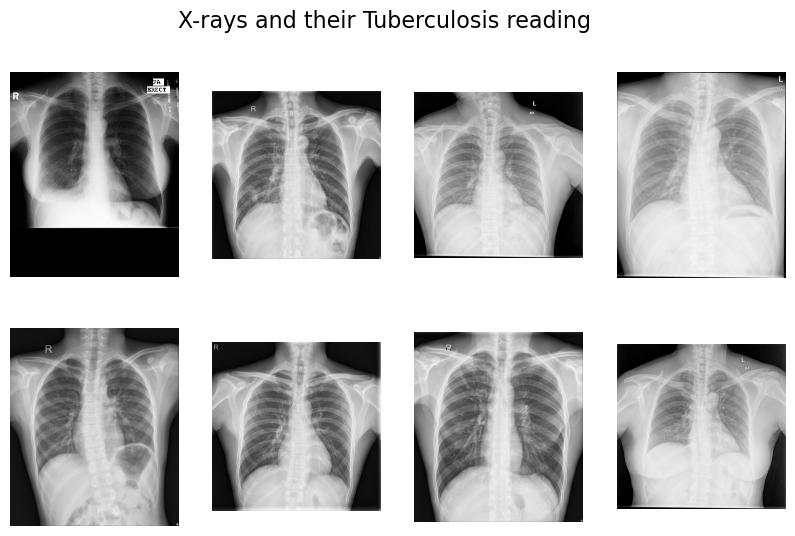

In [15]:
show_images_from_df(img_df, title_col="res", fig_title="X-rays and their Tuberculosis reading")

### Prepare data for torch model

In [ ]:
# Define transforms
train_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4855,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# Simple Dataset wrapper
class XRayDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = row['image']
        
        if self.transform:
            img = self.transform(img)
        
        label = torch.tensor(row['res'], dtype=torch.bool)
        return img, label

In [ ]:
# Split into train/val/test and Dataloaders
full_ds = XRayDataset(img_df, transform=None)
n_val = int(len(full_ds) * 0.1)
n_train = len(full_ds) - n_val * 2

train_ds, val_ds, test_ds = random_split(full_ds, [n_train, n_val, n_val])
train_ds.dataset.transform = train_transforms
val_ds.dataset.transform = val_transforms
train_ds.dataset.transform = val_transforms

# Not sure what optimal num_workers parameter is... should be GPU intensive so maybe less workers
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=8) 
val_loader = DataLoader(val_ds, batch_size=24, shuffle=True, num_workers=8)
train_loader = DataLoader(train_ds, batch_size=24, shuffle=True, num_workers=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

## 🏗️ Training

In [ ]:
# Replace model with convnext model soon

from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm.auto import tqdm

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-2)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

num_epochs = 20
history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}

for epoch in range(1, num_epochs+1):
    # Training
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    pbar = tqdm(train_loader, desc=f"[{epoch}/{num_epochs}] Train ")
    for imgs, labels in pbar:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss    = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = outputs.argmax(dim=1)
        running_loss    += loss.item() * imgs.size(0)
        running_corrects+= (preds==labels).sum().item()
        total           += imgs.size(0)
        pbar.set_postfix(loss=running_loss/total, acc=running_corrects/total)

    epoch_loss = running_loss/total
    epoch_acc  = running_corrects/total

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss    = criterion(outputs, labels)
            preds   = outputs.argmax(dim=1)

            val_loss    += loss.item() * imgs.size(0)
            val_corrects+= (preds==labels).sum().item()
            val_total   += imgs.size(0)

    val_epoch_loss = val_loss / val_total
    val_epoch_acc  = val_corrects / val_total

    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    scheduler.step()

    print(f"Epoch {epoch}/{num_epochs}  "
          f"Train loss {epoch_loss:.4f}  acc {epoch_acc:.4f}  |  "
          f"Val loss {val_epoch_loss:.4f}  acc {val_epoch_acc:.4f}")

## 📜 Results

In [ ]:
epochs = range(1, num_epochs+1)

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(epochs, history['train_loss'], label='Train')
plt.plot(epochs, history['val_loss'],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss Curves')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, history['train_acc'], label='Train')
plt.plot(epochs, history['val_acc'],   label='Val')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()